# Learning in Graphs from the Netzschleuder Repository

## Prerequisites

First, we need to set up our Python environment that has PyTorch, PyTorch Geometric and PathpyG installed. Depending on where you are executing this notebook, this might already be (partially) done. E.g. Google Colab has PyTorch installed by default so we only need to install the remaining dependencies. The DevContainer that is part of our GitHub Repository on the other hand already has all of the necessary dependencies installed. 

In the following, we install the packages for usage in Google Colab using Jupyter magic commands. For other environments comment in or out the commands as necessary. For more details on how to install `pathpyG` especially if you want to install it with GPU-support, we refer to our [documentation](https://www.pathpy.net/dev/getting_started/). Note that `%%capture` discards the full output of the cell to not clutter this tutorial with unnecessary installation details. If you want to print the output, you can comment `%%capture` out.

In [1]:
%%capture
# !pip install torch
!pip install torch_geometric
!pip install git+https://github.com/pathpy/pathpyG.git

## Motivation and Learning Objectives

Access to a large number of graphs with different topological characteristics and from different domains is crucial for the development and evaluation of graph learning methods. Tousands of graph data sets are available scattered throughout the web, possibly using different data formats and with missing information on their actual origin. Addressing this issue the [Netschleuder Online Repository](https://networks.skewed.de/) by Tiago Peixoto provides a single repository of graphs in a single format, including descriptions, citations, and node-/edge- or graph-level meta-data. To facilitate the development of graph learning techniques, pathpyG provides a feature that allows to directly read networks from the netzschleuder repository via an API.

In this brief unit, we will learn how we can retrieve network records and graph data from the netzschleuder repository. We will further demonstrate how we can conveniently apply a Graph Neural Network to predict node-level categories contained in the meta-data.

We first need to import a few modules.

In [1]:
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import torch
from torch.nn import ReLU, Sigmoid

import torch_geometric
from torch_geometric.nn import Sequential, GCNConv

import pathpyG as pp

/opt/conda/lib/python3.11/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 500: named symbol not found (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reading graphs from the netzschleuder repository

In the `pathpy.io` module, there is a function that allows to read graph data from the API. 

We can read a given networks from the netzschleuder database using its record name. Just browse the [Netschleuder Online Repository](https://networks.skewed.de/) to find the record names. As an example, we use a graph capturing co-purchase relationships between political books.



In [10]:
g = pp.io.read_netzschleuder_graph(name='polbooks')
print(g)

Undirected graph with 105 nodes and 441 edges
{   'Edge Attributes': {},
    'Graph Attributes': {   'analyses_average_degree': "<class 'float'>",
                            'analyses_degree_assortativity': "<class 'float'>",
                            'analyses_degree_std_dev': "<class 'float'>",
                            'analyses_diameter': "<class 'int'>",
                            'analyses_edge_properties': "<class 'list'>",
                            'analyses_edge_reciprocity': "<class 'float'>",
                            'analyses_global_clustering': "<class 'float'>",
                            'analyses_hashimoto_radius': "<class 'float'>",
                            'analyses_is_bipartite': "<class 'bool'>",
                            'analyses_is_directed': "<class 'bool'>",
                            'analyses_knn_proj_1': "<class 'float'>",
                            'analyses_knn_proj_2': "<class 'float'>",
                            'analyses_largest_com

We can plot this temporal graph in an interactive way:

In [7]:
pp.plot(g, edge_color='lightgray', edge_size=5)

To see how we can apply GNNs to attributed graphs, let us read the famous karate club network. The record `karate` actually contains two networks with labels `77` and `78`, which refer to two different versions of the data with different numbers of edges. If multiple graph data sets exist in the same record, we can specify the name of the network as second argument.

In [15]:
g = pp.io.read_netzschleuder_graph(name='karate', network='78').to(device)
print(g)

Undirected graph with 34 nodes and 78 edges
{   'Edge Attributes': {},
    'Graph Attributes': {   'analyses_average_degree': "<class 'float'>",
                            'analyses_degree_assortativity': "<class 'float'>",
                            'analyses_degree_std_dev': "<class 'float'>",
                            'analyses_diameter': "<class 'int'>",
                            'analyses_edge_properties': "<class 'list'>",
                            'analyses_edge_reciprocity': "<class 'float'>",
                            'analyses_global_clustering': "<class 'float'>",
                            'analyses_hashimoto_radius': "<class 'float'>",
                            'analyses_is_bipartite': "<class 'bool'>",
                            'analyses_is_directed': "<class 'bool'>",
                            'analyses_knn_proj_1': "<class 'float'>",
                            'analyses_knn_proj_2': "<class 'float'>",
                            'analyses_largest_compo

In [16]:
pp.plot(g, edge_color='gray');

We see that the nodes actually have a `node_groups` property, which maps the nodes to two groups. Those groups are often used as `ground truth` for communities in this simple illustrative graph. We will instead use it as ground truth categorical node label for a node classification experiment based on a Graph Neural Network.

Conveniently, numerical node attributes (either scalar or vector values) are automatically converted to torch tensors, so we can directly use them for a GNN.

In [18]:
print(g.data.node_groups)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


For convenience, let us shift the group labels to binary values 0 and 1: 

In [19]:
g.data.node_groups -= 1
print(g.data.node_groups)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


We can plot categorical labels by passing node colors in the plot function.

In [20]:
pp.plot(g, node_color = [g['node_groups',v].item() for v in g.nodes])

For convenience, let us shift the group labels to binary values 0 and 1: 

In [21]:
color_map = {0: 'red', 1: 'blue'}
colors = [ color_map[g['node_groups',v].item()] for v in g.nodes ]
pp.plot(g, node_color = colors);

## Applying Graph Neural Networks to Netzschleuder Data

To simplify the application of deep learning models, we can retrieve a data object that contains the graph and its attributes:

In [22]:
print(g.data)

Data(edge_index=[2, 156], num_nodes=34, node_sequence=[34, 1], node_name=[34], node_groups=[34], node__pos=[34], analyses_average_degree=4.588235294117647, analyses_degree_assortativity=-0.47561309768461424, analyses_degree_std_dev=3.820360677912828, analyses_diameter=5, analyses_edge_properties=[0], analyses_edge_reciprocity=1.0, analyses_global_clustering=0.2556818181818182, analyses_hashimoto_radius=5.292780644548693, analyses_is_bipartite=False, analyses_is_directed=False, analyses_knn_proj_1=3.6123615105719784, analyses_knn_proj_2=1.4566019942625823, analyses_largest_component_fraction=1.0, analyses_mixing_time=7.04834107126513, analyses_num_edges=78, analyses_num_vertices=34, analyses_transition_gap=0.8677276709836416, analyses_vertex_properties=[3])


Let's use a one-hot encoding of nodes as a simple additional node feature `x`, and let's use the node groups as target label `y`. 

In [23]:
data = g.data
g["node_feature"] = torch.eye(g.n, device=device)
data['x'] = data['node_feature']
data['y'] = data['node_groups'].reshape(-1, 1).float()

It is easy to define a Graph Convolutional Network that ues the one-hot-encodings of nodes and the topology to predict binary node labels:

In [24]:
model = Sequential('node_ohe, edge_index', [
    (GCNConv(in_channels=data.num_node_features, out_channels=8), 'node_ohe, edge_index -> hidden'),
    ReLU(inplace=True),
    (GCNConv(in_channels=8, out_channels=1), 'hidden, edge_index -> output'),
    Sigmoid(),
])
model.to(device)

Sequential(
  (0) - GCNConv(34, 8): node_ohe, edge_index -> hidden
  (1) - ReLU(inplace=True): hidden -> hidden
  (2) - GCNConv(8, 1): hidden, edge_index -> output
  (3) - Sigmoid(): output -> output
)

We next apply a `RandomNodeSplit` transformation to split the nodes in a training and test set.

In [25]:
transform = torch_geometric.transforms.RandomNodeSplit(split='train_rest', num_val=0.5, num_test=0)
data = transform(data)

We then train our model for 1000 epochs on the training set.

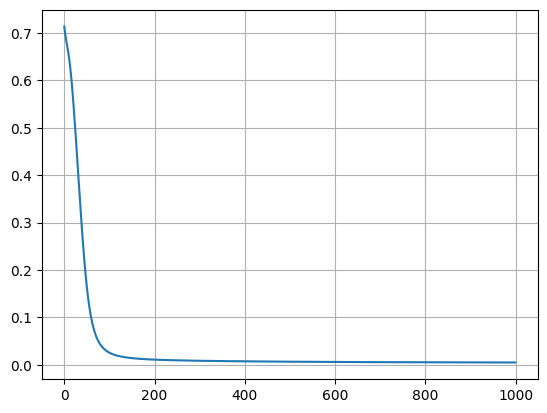

In [26]:
epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.nn.functional.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    losses.append(loss.cpu().detach().numpy())

plt.plot(range(epochs), losses)
plt.grid()

We evaluate the model in the test set and calculate the adjusted mutual information for the ground truth.

In [27]:
model.eval()
predicted_groups = model(data.x, data.edge_index).round().long()
metrics.adjusted_mutual_info_score(data.y[data.test_mask].squeeze().cpu().numpy(), predicted_groups[data.test_mask].squeeze().cpu().numpy())

1.0

We visualize node representations learned by the model. The test nodes are colored, while training nodes are greyed out.

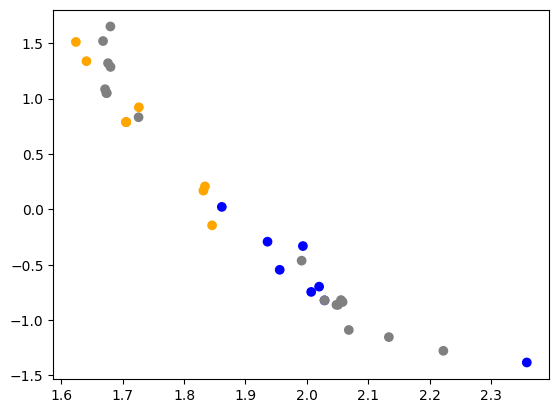

In [28]:
# get activations in first-layer
embedding = model[0].forward(data.x, data.edge_index)

# dimensionality reduction
svd = TruncatedSVD()
low_dim = svd.fit_transform(embedding.cpu().detach().numpy())

# plot with colors corresponding to groups in validation set
colors = {}
for v in range(g.n):
    if not data.val_mask[v]:
        colors[v] = 'grey'
    else:
        if data.y[v].item() == 0.0:
            colors[v] = 'blue'
        else:
            colors[v] = 'orange'

plt.scatter(low_dim[:,0], low_dim[:,1], c=colors.values());

This simple code gives you thousands of networks with various meta information at your fingertips, to wich you can directly apply graph learning models provided in pyG, or deep graoh learning architectures defined by yourself. 